# Hypothesis Testing

## Types of Hypothesis Tests

When trying to estimate something based on sample(s) from a larger population of interest, it is important to formulate specific questions and then quantify uncertainty about the answers. Some situations involve numerical data:

* a professor expects an exam average to be roughly 75%, and wants to know if the actual scores line up with this expectation. Was the test actually too easy or too hard?
* a manager of a chain of stores wants to know if certain locations have different revenues on different days of the week. Are the revenue differences a result of natural fluctuations or a significant difference between the stores' sales patterns?
* a PM for a website wants to compare the time spent on different versions of a homepage. Does one version make users stay on the page significantly longer?

Others involve categorical data, such as:

* a pollster wants to know if men and women have significantly different yogurt flavor preferences. Does a result where men more often answer "chocolate" as their favorite reflect a significant difference in the population?
* do different age groups have significantly different emotional reactions to different ads?

In this lesson, you will learn how about how we can use hypothesis testing to help answer these questions. There are several different types of hypothesis tests for the various scenarios you may encounter. Luckily, SciPy has built-in functions that perform all of these tests for us, normally using just one line of code.

For numerical data, we will cover:

* One Sample T-Tests
* Two Sample T-Tests
* ANOVA
* Tukey Tests

For categorical data, we will cover:

* Binomial Tests
* Chi Square

After this lesson, you will have a wide range of tools in your arsenal to answer questions about your data.

***
### Exercise

Play around with the <a href="https://content.codecademy.com/courses/learn-hypothesis-testing/index.html">applet in the browser</a> to make some different distributions and see if a simple hypothesis test labels them to be significantly different or not.

What happens as you move the means to be farther apart? Is the test more likely to judge the two distributions to be significantly different?

What happens to the test result as you decrease the standard deviations?

With increased sample size, is the test more or less likely to find a difference?

Continue onto the next exercise to learn how to conduct hypothesis tests on your own.

<html>
<head>
<style>
	html, text {
		background-color: #354551;
		color: white;
		font-family: 'Oxygen', sans-serif;
		fill: white;
	}
	body {
		background-color: #354551;
		color: white;
		font-family: 'Oxygen', sans-serif;
		font-size: 16px;
	}
	.domain, line {
		stroke: white;
	}
	span.yes {
		color: green;
		font-weight: bold;
	}
	span.no {
		color: tomato;
		font-weight: bold;
	}
	g.sample1 > rect {
		fill: steelblue;
		opacity: 0.5;
	}
	g.sample2 > rect {
		fill: tomato;
		opacity: 0.5;
	}
	.sample1_label {
		color: steelblue;
	}
	.sample2_label {
		color: tomato;
	}
	td {
		padding: 5px;
	}
	.sample1_label{
		padding-right: 10px
	}

</style>
<script async src='https://content.codecademy.com/cdn-cgi/bm/cv/669835187/api.js'></script></head>
<body>
<svg height="250" width="500"></svg>
<br>
<table>
<tr>
	<th></th>
	<th class="sample1_label">Sample 1</th>
	<th class="sample2_label">Sample 2</th>
</tr>
<tr>
	<td>
	Mean:
	</td>
	<td>
	<input type="number" value="0" step="0.1" min="-1" max="1" id="mean1"></input>
	</td>
	<td>
	<input type="number" value="0.1" step="0.1" min="-1" max="1" id="mean2"></input>
	</td>
</tr>
<tr><td>
	Standard Deviation:
	</td>
	<td>
	<input type="number" value="1" step="0.5" min="1" max="5" id="std1"></input>
	</td>
	<td>
	<input type="number" value="1" step="0.5" min="1" max="5" id="std2"></input>
	</td>
</tr>
<tr><td>
	Number of Samples:
	</td>
	<td>
	<input type="number" value="50" step="25" min="25" max="200" id="nSamples"></input>
	</td>
</tr>
</table>
<br>
<span>P-value: <span id="pvalue"></span></span>
<br>
<br>
<span>Significantly different? <span id="sig"></span></span>
<br>
<br>
<button id="generate" onclick="update()">Generate </button>

<script src="https://unpkg.com/simple-statistics@5.1.0/dist/simple-statistics.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jstat@latest/dist/jstat.min.js"></script>
<script src="https://d3js.org/d3.v4.min.js"></script>

<script>
var ids = ['mean1', 'mean2', 'std1', 'std2', 'nSamples'];
var xMin = -3; // Min x-value plotted
var xMax = 3; // Max x-value plotted
var nBins = 30; // Number of bins
var svgWidth = 500; // Width of SVG
var svgHeight = 250; // Height of SVG
var mean = 0; // Initial mean
var std = 1; // Initial std
var xScale = d3.scaleLinear()
  	.range([0, svgWidth])
    .domain([xMin * 1.1, xMax * 1.1]);
var yScale = d3.scaleLinear()
  	.range([0, svgHeight])
    .domain([0, 25]);

function setUp() {
	var svg = d3.select('svg');
	var binXs = genBinXs(xMin, xMax, nBins);
	d3.select('svg')
		.selectAll('g')
		.data(['sample1', 'sample2'])
		.enter()
		.append('g')
		.attr('class', function(d) {return d})
		.selectAll('rect')
		.data(binXs)
		.enter()
		.append('rect')
		.attr('x', function(d, i) {return d})
		.attr('width', binXs[1] - binXs[0]);

	ids.forEach(function(id) {
		d3.select('#' + id)
			.on('update', update);
	});
	update();

	var xAxis = d3.axisBottom()
                  .scale(xScale)
                  .ticks(5);  //Set rough # of ticks
    svg.append("g")
       .attr("transform", "translate(0,"+(svgHeight-30)+")")
       .call(xAxis);
}

function update() {
	var std1 = parseFloat(d3.select('#std1')._groups[0][0].value);
	var mean1 = parseFloat(d3.select('#mean1')._groups[0][0].value);
	var std2 = parseFloat(d3.select('#std2')._groups[0][0].value);
	var mean2 = parseFloat(d3.select('#mean2')._groups[0][0].value);
	var nSamples = parseFloat(d3.select('#nSamples')._groups[0][0].value);
	var binXs = genBinXs(xMin, xMax, nBins);
	var samples1 = genSamples(mean1, std1, nSamples);
	var samples2 = genSamples(mean2, std2, nSamples);
	var binHeights1 = genBinHeights(xMin, xMax, nBins, samples1);
	var binHeights2 = genBinHeights(xMin, xMax, nBins, samples2);
	// Plot Histograms
	d3.select('g.sample1')
		.selectAll('rect')
		.transition()
		.attr('y', function(d, i) {return (svgHeight-30) - binHeights1[i]})
		.attr('height', function(d, i) {return binHeights1[i]});
	d3.select('g.sample2')
		.selectAll('rect')
		.transition()
		.attr('y', function(d, i) {return (svgHeight-30) - binHeights2[i]})
		.attr('height', function(d, i) {return binHeights2[i]});
	// Significance Test
	var pval = ttest(samples1, samples2);
	d3.select('#pvalue')
		.html(pval.toFixed(2));	
	if (pval < 0.05) {
		d3.select('#sig')
			.html('Yes')
			.attr('class', 'yes');
	} else {
		d3.select('#sig')
			.html('No')
			.attr('class', 'no');
	}
}

function calc_within_1std(samples, mean, std) {
	var p = 0;
  samples.forEach(function(d) {
  	if ((d > (mean - std)) & (d < (mean + std))) {
    	p++;
    }
  });
  return Math.round(1000 * p / samples.length) / 10;
}

function genSamples(mean, std, nSamples) {
	var samples = [];
	for (i=0; i < nSamples; ++i) {
  	samples[i] = jStat.normal.sample( mean , std ) ;
  }
  return samples
}

function genBinXs(xMin, xMax, nBins) {
	var binWidth = (xMax - xMin) / nBins;
  var xVals = [];
	for (var i=0; i<nBins; i++) {
  	xVals[i] = xScale(xMin + (i * binWidth));
  }
  return xVals;
}

function genBinHeights(xMin, xMax, nBins, samples) {
	var binWidth = (xMax - xMin) / nBins;
  var heights = [];
	for (var i=0; i<nBins; i++) {
  	var b = 0;
    samples.forEach(function(x) {
    	var binLeft = xMin + (i * binWidth);
      var binRight = xMin + ((i + 1) * binWidth);
    	if ((x >= binLeft) & (x < binRight)) {
      	b++;
      }
    });
  	heights[i] = yScale(b)
  }
  return heights
}

function ttest(s1 , s2) {
	tstat = ss.tTestTwoSample(s1, s2);
	dof = s1.length + s2.length - 2;
	if (tstat < 0) {
		return jStat.studentt.cdf(tstat, dof) * 2
	} else {
		return (1 - jStat.studentt.cdf(tstat, dof)) * 2
	}
}

setUp();
</script>
<script type="text/javascript">(function(){window['__CF$cv$params']={r:'622895559dfe3323',m:'554001e9d344b44355a77bdc307609438ff27f39-1613492294-1800-ASUWrM/s2pcpGxUVkV34WQdzNkFKYzzE36cp3P6xeyylXsXrJwW8XNcSituHJI1/0rjHKqxD+arDMP8yHmhoEwfdF2mIBmQaGpAIx6qUIeNXMTBZFiiweYp4ueNAK/MSevK2vSV/k/jEne8dHszOb2gZFuEcwGQ1FNdDqoIieyQ6',s:[0x62b5c847f9,0x48eb68f0d3],}})();</script></body>
</html>

***

# 1 Sample T-Testing

Let us imagine the fictional business BuyPie, which sends ingredients for pies to your household so that you can make them from scratch. Suppose that a product manager wants online BuyPie orders to cost around 1000 Rupees on average. In the past day, 50 people made an online purchase and the average payment per order was only 980 Rupees. Are people really spending less than 1000 Rupees on average? Or is this just the result of chance and a small sample size?

We can test this using a _1 Sample T Test_, which compares a sample mean to a hypothetical population mean.

When we conduct a 1 Sample T Test, we want to first create a _null hypothesis_, which is a prediction that the observed sample comes from a population with a particular mean. For example: "the average cost of a BuyPie order is 1000 Rupees". Note that, even if the null hypothesis were true, it's very unlikely that any observed sample mean will be exactly $1000.00$ Rupees.

We also have to determine an _alternative hypothesis_, which is a statement about the kind of difference we are interested in. For example, we might form the following alternative hypothesis: "The average cost of a BuyPie order is **not** $1000$ Rupees".

If we form the null and alternative tests as indicated above, the test asks the following question: "Suppose that that the average cost of a BuyPie order is $1000$ Rupees; what is the probability of observing a sample of $50$ orders with cost **as different** or **more different** from $1000$ as we did (i.e., $< 980$ or $> 1020$)?"

The result of the test is a _p-value_. If the p-value is less than our pre-chosen threshold (usually .05), we can reject the null hypothesis in favor of the alternative. When we reject the null, we are saying that it would be unlikely to observe our sample (or something more extreme) if the null hypothesis were true.

SciPy has a function called `ttest_1samp`, which performs a 1 Sample T-Test for you.

`ttest_1samp` requires two inputs, a sample distribution (eg. the list of the $50$ observed purchase prices) and a mean to test against (eg. `1000`):

    tstat, pval = ttest_1samp(example_distribution, expected_mean)
    print(pval)

It also returns two outputs: the t-statistic (which we will not cover in this course), and the p-value — telling us how confident we can be that the sample of values came from a distribution with the specified mean.

***

### Exercise

1. We have provided a small dataset called `prices`, representing the purchase prices of customers to BuyPie.com in the past hour.

    First examine the numbers.

In [1]:
from scipy.stats import ttest_1samp
import numpy as np

prices = [978., 1080., 999., 855., 1105., 961., 899., 1061., 880., 1455., 505., 936., 1024., 982.]

2. Even with a small dataset like this, it is hard to make judgments from just looking at the numbers.

    To understand the data better, let us look at the mean. Calculate the mean of `prices` using `np.mean`. Store it in a variable called `prices_mean` and print it out.

In [2]:
prices_mean = np.mean(prices)

3. Use `ttest_1samp` with prices to see what p-value the experiment returns for this distribution, where we expect the mean to be `1000`.

    Store the p-value in a variable called `pval`. Remember that it is the second output of the `ttest_1samp` function. We will not use the first output, the t-statistic, so you can store it in a variable with whatever name you like.

In [3]:
expected_mean = 1000
tstat, pval = ttest_1samp(prices, expected_mean)

4. Print out `pval`. Does the p-value you got with the 1 Sample T-Test make sense, knowing the mean of `prices`?

In [4]:
pval

0.7143713930133531

**A:** The p-value is much higher than $0.05$, we therefore cannot reject the the null hypothesis ("Average cost of a BuyPie order is 1000 Rupees")

***

## One Sample T-Test II

In the last exercise, we got a p-value that was much higher than $0.05$, so we cannot reject the null hypothesis. If we conduct another experiment and take a new sample of orders, will we get the same result? Not necessarily!

Just because we don't have enough data to detect a difference does not mean that there is not one. Generally, the larger the sample(s) we have, the smaller a difference we will be able to detect. You can learn more about the exact relationship between sample size and detectable differences in the Sample Size Determination course.

It is also possible that the true mean order price really is $1000$ Rupees, but a single sample still leads us to incorrectly reject the null hypothesis. Remember that this is called _Type 1 Error_ and the significance threshold we use for our test should be equal to the type 1 error rate under the null hypothesis. In other words, if we set a 0.05 significance threshold and the true mean purchase price is truly $1000$ Rupees, we still expect to incorrectly reject the null (and say that the mean is not $1000$ Rupees) in $5\%$ of experiments.

To build intuition for the limitations of conclusions based on any individual sample, let us explore some more data from BuyPie.com and see whether we consistently observe the same results.

***
### Exercise

In [5]:
from scipy.stats import ttest_1samp
import numpy as np

daily_prices = np.genfromtxt("daily_prices.csv", delimiter=",")

1. We have loaded a dataset `daily_prices` that represents the purchase prices of orders from BuyPie.com in the last 1000 days. Each entry `daily_prices[i]` is an array of entries representing the price per order on day `i`.

    We predicted that the average price of an order would be $1000$ Rupees, and we want to know if the actual data differs from that.

    We have made a for loop that goes through the `1000` inner lists. Inside this loop, perform a 1 Sample T-Test with each day of data (`daily_prices[i]`). For now, just print out the p-value from each test.

In [6]:
expected_mean = 1000

for i in range(1000): # 1000 experiments
   #your ttest here:
   tstat, pval = ttest_1samp(daily_prices[i], expected_mean)
   #print the pvalue here:
   print(i, pval)

140 0.8434254583064367
141 0.6294744901786404
142 0.48725176917169266
143 0.9609636394554765
144 0.8545009998050552
145 0.16201975901053373
146 0.9652930901366512
147 0.633983735253068
148 0.6775704926940096
149 0.8197201931659983
150 0.5780932768398179
151 0.7639171929549944
152 0.2890628258828162
153 0.03484237947558212
154 0.43695758583964917
155 0.5710831671949101
156 0.3216007120510659
157 0.3589147739177526
158 0.8102566768060806
159 0.2302195341238871
160 0.222428043054877
161 0.6152661174673769
162 0.748525437746957
163 0.907832411750021
164 0.44026660003689466
165 0.9042192478808109
166 0.6373897876496724
167 0.08409147810336533
168 0.7451085540527895
169 0.4841639829296629
170 0.6388800443877387
171 0.11032158789967837
172 0.5897345754988126
173 0.21507930787988455
174 0.4251544815877841
175 0.05320590535719278
176 0.2565987494636594
177 0.9332718397610217
178 0.7118534337532022
179 0.2881748540118542
180 0.017108722626713365
181 0.6774084559460183
182 0.36650181150728156
183

2. If we get a `pval` < $0.05$, we can conclude that it is unlikely that our sample has a true mean of $1000$. Suppose that the true mean purchase price really is $1000$ Rupees. Thus, if we get a p-value less than $0.05$, we will incorrectly reject the null hypothesis test and say that the experiment indicates the mean purchase price is **not** 1000 Rupees.

    Below the t-test, add some code to check whether the outcome of the hypothesis test is incorrect (i.e., the p-value is less than $.05$). If so, add `1` to `incorrect_results`.

    Now, `incorrect_results` is a count of the number of times the outcome of the test was incorrect. Code has been provided for you to print this number to the console. Since our significance threshold was $0.05$, we expect about $5\%$ or $50$ of the $1000$ experiments to return an incorrect result. Is the number you observe close to $50$?

In [7]:
incorrect_results = 0

for i in range(1000):
   tstat, pval = ttest_1samp(daily_prices[i], 1000)
   if pval < 0.05:
       incorrect_results += 1

incorrect_results

55

***

## 2 Sample T-Test

Suppose that a company has recently updated their website to make it more colorful and inviting. The company wants to know whether the new design is resulting in visitors staying on the site for a longer period of time. A sample of $100$ visitors who saw the old design spent an average of 25 minutes on the site. A second sample of $100$ visitors who saw the new version spent an average of $28$ minutes on the site. Did the average time spent per visitor vary across groups? Or is this difference attributable to random chance?

One way of testing whether this difference is significant is by using a _2 Sample T-Test_. A 2 Sample T-Test compares two sets of numerical data.

The null hypothesis of a 2 Sample T-Test is that the two observed samples come from populations with the same mean. In the example above, this means: if we could observe all site visitors in two alternate universes (one where they see each version of the site), the average visiting times in these universes would be equal.

The alternative hypothesis could be: The two observed samples come from populations with **different** means. In the example above, this would mean that the average visiting times in our two alternate universes are actually different, hence why we observed a difference in our samples.

We can use SciPy's `ttest_ind` function to perform a 2 Sample T-Test. It takes the two samples as inputs and returns the t-statistic and a p-value, which we can use to assess the probability of an observed difference happening by chance if the null hypothesis were true. For more information about p-values, refer to the earlier exercise on univariate t-tests.

***
### Exercise

In [8]:
week1 = np.genfromtxt("week1.csv",  delimiter=",")
week2 = np.genfromtxt("week2.csv",  delimiter=",")

1. We have created two distributions representing the time spent per visitor to BuyPie.com last week, `week1`, and the time spent per visitor to BuyPie.com this week, `week2`.

    Find the means of these two distributions. Store them in `week1_mean` and `week2_mean.` Print the values.

In [9]:
week1_mean = np.mean(week1)
week2_mean = np.mean(week2)

print(week1_mean)
print(week2_mean)

25.448059395144654
29.021568107746155


2. Find the standard deviations of these two distributions. Store them in `week1_std` and `week2_std`. Print the values.

In [10]:
week1_std = np.std(week1)
week2_std = np.std(week2)

print(week1_std)
print(week2_std)

4.531693387084315
5.497966708653651


3. Run a 2 Sample T-Test using the SciPy function `ttest_ind`.

    Save the p-value in a variable called `pval` and print it out. Does this value make sense, knowing what you know about these datasets?

In [11]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(week1, week2)

pval

0.0006767676900067757

**A:** Even though the mean of week2 is higher it also has a higher standard deviation. With a very low p-value (much lower than $0.05$) returned from `ttest_ind` we cannot be sure the population mean is actually different between these two samples.

***

## Dangers of Multiple T-Tests

Suppose that we own a chain of stores that sell ants, called VeryAnts. There are three different locations: $A$, $B$, and $C$. We want to know if the average ant sales over the past year are significantly different between the three locations.

At first, it seems that we could perform t-tests between each pair of stores.

We know that the p-value is the probability that we incorrectly reject the null hypothesis on each t-test. The more t-tests we perform, the more likely that we are to get a false positive, a Type I error.

For a significance threshold of $0.05$, if the null hypothesis is true, then the probability of correctly failing to reject the null is $1 – 0.05 = 0.95$. When we run another t-test where the null is true, the probability of correctly failing to reject the null on both of those tests is $0.95 * 0.95$, or $0.9025$. That means our probability of making an error is now $1 - 0.9025$, or close to 10%! This error probability only gets bigger with the more t-tests we do.

***
### Exercise

In [12]:
a_sample = np.genfromtxt("store_a.csv",  delimiter=",")
b_sample = np.genfromtxt("store_b.csv",  delimiter=",")
c_sample = np.genfromtxt("store_c.csv",  delimiter=",")

1. We have created samples `a_sample`, `b_sample`, and `c_sample`, representing the sales at VeryAnts at locations $A$, $B$, and $C$, respectively. We want to see if there is a significant difference in sales between the three locations.

    Explore datasets `a_sample`, `b_sample`, and `c_sample` by finding and printing the means and standard deviations of each one. Store the means in variables called `a_mean`, `b_mean`, and `c_mean`. Store the standard deviations in variables called `a_std`, `b_std`, and `c_std`.

In [13]:
a_mean, a_std = np.mean(a_sample), np.std(a_sample)
b_mean, b_std = np.mean(b_sample), np.std(b_sample)
c_mean, c_std = np.mean(c_sample), np.std(c_sample)

print(f"Dataset 'a' - Mean: {a_mean:.2f}, Standard Deviation: {a_std:.2f}")
print(f"Dataset 'b' - Mean: {b_mean:.2f}, Standard Deviation: {b_std:.2f}")
print(f"Dataset 'c' - Mean: {c_mean:.2f}, Standard Deviation: {c_std:.2f}")

Dataset 'a' - Mean: 58.35, Standard Deviation: 14.75
Dataset 'b' - Mean: 65.63, Standard Deviation: 14.75
Dataset 'c' - Mean: 62.36, Standard Deviation: 15.09


2. Perform a 2-Sample T-test between each pair of location data.

    Store the p-values in variables called `a_b_pval`, `a_c_pval`, and `b_c_pval`. Print the values.

In [14]:
a_b_tstat, a_b_pval = ttest_ind(a_sample, b_sample)
a_c_tstat, a_c_pval = ttest_ind(a_sample, c_sample)
b_c_tstat, b_c_pval = ttest_ind(b_sample, c_sample)

print(f"Comparison 'a-b' - p-Value: {a_b_tstat:.2f}")
print(f"Comparison 'a-c' - p-Value: {a_c_tstat:.2f}")
print(f"Comparison 'b-c' - p-Value: {b_c_tstat:.2f}")

Comparison 'a-b' - p-Value: -4.26
Comparison 'a-c' - p-Value: -2.32
Comparison 'b-c' - p-Value: 1.89


3. Store the probability of error in a variable called `error_prob`. Print it out to the console.

In [15]:
error_prob = 1 - 0.95 ** 3
print(f"{error_prob:.2%}")

14.26%


## ANOVA

In the last exercise, we saw that the probability of making a Type I error got dangerously high as we performed more t-tests.

When comparing more than two numerical datasets, one way to preserve a Type I error probability of $0.05$ is to use _ANOVA_. ANOVA (Analysis of Variance) tests the null hypothesis that all of the samples come from populations with the same mean. If we reject the null hypothesis with ANOVA, we are saying that at least one pair of populations (from which the samples were drawn) have different means; however, we cannot determine exactly which pair(s).

We can use the SciPy function `f_oneway` to perform ANOVA on multiple datasets. `f_oneway` takes in each dataset as a different input and returns the F-statistic and the p-value. For example, if we were comparing scores on a videogame between math majors, writing majors, and psychology majors, we could run an ANOVA test with this line:

    fstat, pval = f_oneway(scores_mathematicians, scores_writers, scores_psychologists)

The null hypothesis, in this case, is that all three populations have the same mean score on this videogame. If we reject this null hypothesis (if we get a p-value less than $0.05$), we can say that we are reasonably confident that at least one pair of populations is significantly different. After using only ANOVA, we cannot make any conclusions on which two populations have a significant difference.

Let us look at an example of ANOVA in action.

***
### Exercise

In [16]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np

a_sample = np.genfromtxt("store_a.csv",  delimiter=",")
b_sample = np.genfromtxt("store_b.csv",  delimiter=",")
c_sample = np.genfromtxt("store_c.csv",  delimiter=",")

1. Perform an ANOVA test on `a_sample`, `b_sample`, and `c_sample` and store the p-value in a variable called `pval`.

In [17]:
fstat, pval = f_oneway(a_sample, b_sample, c_sample)

2. Print out your `pval`. Does this p-value lead you to reject the null hypothesis?

In [18]:
pval

0.0001534116600777967

**A:** Since our p-Value is much smaller than $0.05$ we have to reject the null hypothesis that the sales between the three stores come from a population with the same mean.

3. Let us say the sales at location $B$ have suddenly _soared_ (maybe there is an ant convention happening nearby). Change the mean of the `b_sample` distribution to be loaded from 'store_b_new.csv', instead of 'store_b.csv'.

    Re-run the ANOVA test and see what the p-value is now. Does this new value make sense?

In [19]:
a_sample = np.genfromtxt("store_a.csv",  delimiter=",")
b_sample = np.genfromtxt("store_b_new.csv",  delimiter=",")
c_sample = np.genfromtxt("store_c.csv",  delimiter=",")

fstat, pval = f_oneway(a_sample, b_sample, c_sample)
pval

8.49989098083282e-215

**A:** Since the sales for store $B$ are much higher we expect our p-value to be even lower.

***

## Assumptions of T-Tests and ANOVA

Before we use one or two sample t-tests or ANOVA, we need to be sure that the following things are true:

### 1. The sample(s) should be normally distributed…ish

Data analysts in the real world often still perform t-tests or ANOVAs on data that are not normally distributed. This is usually not a problem if sample size is large, but it depends on how non-normal the data is. In general, the bigger the sample size, the safer you are!

### 2. The standard deviations of the samples should be equal

For ANOVA and 2-Sample T-Tests, using datasets with standard deviations that are significantly different from each other will often obscure the differences in group means. That said, there is also a way to run a 2-Sample T-Test without assuming equal standard deviations (for example, by setting the `equal_var` parameter in the `scipy.stats.ttest_ind()` function equal to `False`). Running the test in this way has some disadvantages (it essentially makes it harder to reject the null hypothesis even when there is a true difference between groups), so it’s important to check for equal standard deviations before running a test.

To check this assumption, it is normally sufficient to divide the two standard deviations and see if the ratio is "close enough" to $1$. "Close enough" may differ in different contexts but generally staying within $10\%$ should suffice. This equates to a ratio between $0.9$ and $1.1$.

### 3. The samples must be independent

When comparing two or more datasets, the values in one distribution should not affect the values in another distribution. In other words, knowing more about one distribution should not give you any information about any other distribution.

Here are some examples where it would seem the samples are not independent:

* the number of goals scored per soccer player before, during, and after undergoing a rigorous training regimen
* a group of patients' blood pressure levels before, during, and after the administration of a drug

It is important to understand your datasets before you begin conducting hypothesis tests on them so that you know you are choosing the right test.

***
### Exercise

In [20]:
import numpy as np
import matplotlib.pyplot as plt

dist_1 = np.genfromtxt("dist_1.csv",  delimiter=",")
dist_2 = np.genfromtxt("dist_2.csv",  delimiter=",")

1. Use Matplotlib's `plt.hist()` function to display `dist_1` before the call to `plt.show()`. Does it look like this distribution is normal? (note: a normal distribution has a single mode or hump and is symmetric)

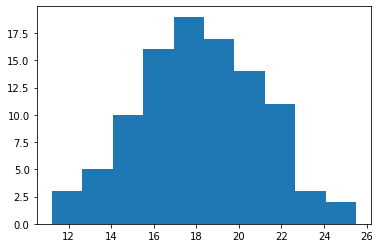

In [21]:
plt.hist(dist_1)
plt.show()

**A:** Yes, `dist_1` looks like a normal distribution.

2. Calculate the ratio of standard deviations between `dist_1` and `dist_2` and store it in a variable called `ratio`. Print it to the console. Is this "close enough" to perform a numerical hypothesis test between the two datasets?

In [22]:
ratio = np.std(dist_1) / np.std(dist_2)
ratio

0.5814221080397466

**A:** For the ratio to be considered "close enough" it should be between $0.9$ and $1.1$. The calculated ratio is around $0.58$ and therefore not "close enough".

***

## Tukey's Range Test

Let us say that we have performed ANOVA to compare three sets of data from the three VeryAnts stores. We received the result that there is some significant difference between datasets.

Now, we have to find out _which_ datasets are different.

We can perform a _Tukey's Range Test_ to determine the difference between datasets.

If we feed in three datasets, such as the sales at the VeryAnts store locations $A$, $B$, and $C$, Tukey's Test can tell us which pairs of locations are distinguishable from each other.

The function to perform Tukey's Range Test is `pairwise_tukeyhsd`, which is found in `statsmodel`, not `scipy`. We have to provide the function with one list of all of the data and a list of labels that tell the function which elements of the list are from which set. We also provide the significance level we want, which is usually `0.05`.

For example, if we were looking to compare mean scores of movies that are dramas, comedies, or documentaries, we would make a call to `pairwise_tukeyhsd` like this:

    movie_scores = np.concatenate([drama_scores, comedy_scores, documentary_scores])
    labels = ['drama'] * len(drama_scores) + ['comedy'] * len(comedy_scores) + ['documentary'] * len(documentary_scores)
 
    tukey_results = pairwise_tukeyhsd(movie_scores, labels, 0.05)

It will return a table of information, telling you whether or not to reject the null hypothesis for each pair of datasets.

***
### Exercise

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import numpy as np

a_sample = np.genfromtxt("store_a.csv",  delimiter=",")
b_sample = np.genfromtxt("store_b.csv",  delimiter=",")
c_sample = np.genfromtxt("store_c.csv",  delimiter=",")

stat, pval = f_oneway(a_sample, b_sample, c_sample)

pval

0.0001534116600777967

In [24]:
# Using our data from ANOVA, we create values and labels
values = np.concatenate([a_sample, b_sample, c_sample])
labels = ['store_a'] * len(a_sample) + ['store_b'] * len(b_sample) + ['store_c'] * len(c_sample)

1. We have concatenated the sales data in lists `a_sample`, `b_sample`, and `c_sample` and put it into list `values`. We have also provided a `labels` list that keeps track of which elements of `values` come from `a_sample`, `b_sample`, or `c_sample`.

    Use `pairwise_tukeyhsd` with these two lists and `0.05` (the desired significance level) as inputs. Store the results in a variable called `tukey_results`.

In [25]:
significance_level = 0.05
tukey_results = pairwise_tukeyhsd(values, labels, significance_level)

print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
store_a store_b   7.2767  0.001  3.2266 11.3267   True
store_a store_c   4.0115 0.0529 -0.0385  8.0616  False
store_b store_c  -3.2651 0.1411 -7.3152  0.7849  False
------------------------------------------------------


***

## Binomial Test

Let us imagine that we are analyzing the percentage of customers who make a purchase after visiting a website. $1000$ customers visited the site this month, and $58$ of them made a purchase. The marketing department reports that historical data suggests about $72$ of every $1000$ visitors make a purchase. Thus, they estimate that the probability of any particular customer making a purchase is $7.2\%$. We would like to know if this month's number, $58$ purchases, is significantly different from normal or a reasonable fluctuation due to random chance.

In previous exercises, we collected samples of numerical information (eg. order price) and then used the mean and standard deviation of those samples to make comparisons. In contrast, we now have a sample where each unit (a visitor) falls into one of two discrete categories:

* "made a purchase"
* "did not make a purchase"

Instead of comparing sample means, we want to compare the percent in the "made a purchase" category to some expectation. This can be done with a _Binomial Test_. The binomial distribution describes the number of expected "successes" in an experiment with some number of "trials". In this case, our experiment consists of $1000$ people visiting the site. For each of those trials (visitors), we expect that there is a $7.2\%$ chance of a purchase (success).

SciPy has a function called `binom_test()`, which performs a Binomial Test for you. In this example, the null hypothesis is that the true probability of a purchase is $7.2\%$. The default alternative hypothesis for the `binom_test()` function in this example is that the true probability is not $7.2\%$.

`binom_test()` requires three inputs, the number of observed successes, the number of total trials, and an expected probability of success. For example, with $1000$ coin flips of a fair coin, we would expect a "success rate" (the rate of getting heads), to be $0.5$, and the number of trials to be $1000$. Let us imagine we get $525$ heads. Is the coin weighted? This function call would look like:

    pval = binom_test(525, n=1000, p=0.5)

It returns a p-value, telling us how likely we are to observe at least this much deviation from expectation ($> 525$ heads or $< 475$ heads) given that the true probability of heads on any flip was $0.5$ (meaning our expectation was $500$ heads). If we get a p-value less than $0.05$, we can reject the null hypothesis and say it is unlikely that the true probability of heads was $0.5$ on each flip, suggesting that the coin is weighted.

***
### Exercise

In [26]:
from scipy.stats import binom_test

1. Suppose the goal of VeryAnts's marketing team this quarter was to have $6\%$ of customers click a link that was emailed to them. They sent out a link to $10,000$ customers and $510$ clicked the link, which comes out to $5.1\%$ instead of $6\%$. Did they do significantly worse than the target? Let us use a binomial test to answer this question.

    Use SciPy's `binom_test` function to calculate the p-value the experiment returns for this distribution, where we wanted the mean to be $6\%$ of emails opened, or `p=0.06`, but only saw $5.1\%$ of emails opened.

    Store the p-value in a variable called `pval` and print it out.

In [27]:
pval = binom_test(510, n=10000, p=0.06)
pval

0.00011592032724546606

2. For the next quarter, marketing has tried out a new email tactic, including puns in every line of every email. As a result, $590$ people out of $10000$ opened the link in the newest email.

    If we still wanted the mean to be $6\%$ of emails opened, but now have $5.9\%$ of emails opened, what is the new p-value. Save your results to the variable `pval2`

    Does this new p-value make sense?

In [28]:
pval2 = binom_test(590, n=10000, p=0.06)
pval2

0.6891529835730346

**A:** For 1. it is very unlikely that the target of $6\%$ was hit as the p-value is much smaller than $0.05$. For 2. it is very likely that the target of $6\%$ was hit as the p-value is much greater than $0.05$.

***

## Chi Square Test

In the last exercise, we looked at data where customers visited a website and either made a purchase or did not make a purchase. What if we also wanted to understand if the probability of making a purchase depends on some other categorical variable, like gender? If we want to understand whether the outcomes of two categorical variables are associated, we should use a _Chi Square_ test. It is useful in situations like:

* An A/B test where half of users were shown a green submit button and the other half were shown a purple submit button. Was one group more likely to click the submit button?
* People under and over age 40 were given a survey asking “Which of the following three products is your favorite?” Did these age groups have significantly different preferences?

In SciPy, you can use the function `chi2_contingency` to perform a Chi Square test.

The input to `chi2_contingency` is a contingency table where:

* The columns are each a different condition, such as Interface A vs. Interface B
* The rows represent different outcomes, like "Clicked a Link" vs. "Did not Click"

This table can have as many rows and columns as you need.

Let us return to the question of whether gender is associated with the probability of a website visitor making a purchase. The null hypothesis is that there is no association between the variables (eg. males, females, and non-binary people are all equally likely to make a purchase on the website, so gender and purchase-status are not associated). If the p-value is below our chosen threshold (often $0.05$), we reject the null hypothesis and can conclude there is a statistically significant association between the two variables (eg. men, women, and non-binary people appear to have different probabilities of making a purchase, so gender is associated with purchase-status).

***

### Exercise

1. The management at the VeryAnts ant store wants to know if their two most popular species of ants, the Leaf Cutter and the Harvester, vary in popularity between 1st, 2nd, and 3rd graders.

    We have created a table representing the different ants bought by the children in grades 1, 2, and 3 after the last big field trip to VeryAnts. Run the code to see what happens when we enter this table into SciPy's chi-square test.

    Does the resulting p-value mean that we should reject or accept the null hypothesis?

In [29]:
from scipy.stats import chi2_contingency

# Contingency table
#        | harvester| leaf cutter
# -------+----------+------------
# 1st gr | 30       | 10
# 2nd gr | 35       | 5
# 3rd gr | 28       | 12

X = [[30, 10],
     [35, 5],
     [28, 12]]

chi2, pval, dof, expected = chi2_contingency(X)
pval

0.15508230807673704

**A:** As the p-value is much greater than $0.05$ we cannot reject the null hypothesis and therefore can conclude that there is **no** statistically significant association between the different grades and the most popular ant species.

2. A class of $40$ 4th graders comes into VeryAnts in the next week and buys $20$ sets of Leaf Cutter ants and $20$ sets of Harvester ants.

    Add this data to the contingency table, rerun the chi-square test, and see if there is now a low enough value to reject the null hypothesis.

In [30]:
# Contingency table
#        | harvester| leaf cutter
# -------+----------+------------
# 1st gr | 30       | 10
# 2nd gr | 35       | 5
# 3rd gr | 28       | 12
# 4th gr | 20       | 20

X = [[30, 10],
     [35, 5],
     [28, 12],
     [20, 20]]

chi2, pval, dof, expected = chi2_contingency(X)
pval

0.002812834559546625

**A:** As the p-value is much smaller than $0.05$ we can reject the null hypothesis and therefore can conclude that there **is** a statistically significant association between the different grades and the most popular ant species.